# A/B Testing via Simulation/Randomization

This notebook is to carryout A/B testing on real data. We will work with part of the [data](https://scholarworks.montana.edu/xmlui/handle/1/3507) from ["Improving Library User Experience with A/B Testing: Principles and Process"](https://quod.lib.umich.edu/w/weave/12535642.0001.101?view=text;rgn=main) by Young (2014). This paper presents a case study where A/B testing is applied with different webpage designs. The primary aim is to compare user interactions to determine which one statistically improves the navigation experience by increasing the homepage CTR. The experiment was conducted using the web analytics software Google Analytics and [Crazy Egg](https://www.crazyegg.com/). The setup was done in the Montana State University's library webpage.

The experimental treatments are the following: *Interact* (the **control** treatment), *Connect*, *Learn*, *Help*, and *Services*. **To simplify, this notebook will only work with *Interact* and *Services*.**


As mentioned in the paper, a successful framework for an A/B test follows these steps:

1. Define a research question
2. Refine the question with user interviews
3. Formulate a hypothesis, identify appropriate tools, and define test metrics
4. Set up and run experiment
5. Collect data and **analyze results**
6. Share results and make decision

Here we only focus on the hypothesis testing(analyze results) part with the data provided.

## 1. Six Steps of Hypothesis Testing

1. Define your null and alternative hypotheses.
2. Compute the **observed** test statistic $\delta^*$ coming from your original sample.
3. Use the null model to generate $r$ **random permuted** samples from the original sample and calculate their corresponding $r$ test statistics.
4. Generate the null distribution using these $r$ test statistics.
5. Check where your **observed** test statistic $\delta^*$ falls on this distribution.
6. If $\delta^*$ is near the extremes past some threshold defined with a significance level $\alpha$, we reject the null hypothesis. Otherwise, we fail to reject the null hypothesis.

### This is the `infer` workflow:

![figure](img/infer_workflow.png)

Image from [*Ismay and Kim (2021)*](https://moderndive.com/9-hypothesis-testing.html#infer-workflow-ht).


## 2. Why running an A/B testing?

According to the click heatmap, there was a low user engagement in the *Interact* section (i.e., the control treatment).

![figure](img/heatmap.png)

Image from <a href="https://quod.lib.umich.edu/w/weave/12535642.0001.101?view=text;rgn=main">Young (2014).


### The difference between both treatments

![figure](img/difference.png)

Image from <a href="https://quod.lib.umich.edu/w/weave/12535642.0001.101?view=text;rgn=main">Young (2014).*


### The metric in this case

It is the homepage CTR for the $i$th treatment:

$$p_i = \frac{\text{Total number of clicks on the target button in the $i$th treatment}}{\text{Total number of clicks on the $i$th homepage's treatment}}$$

## 3. Implementing Hypothesis Testing

### 3.1. Loading `R` Packages

Let us load the libraries for data wrangling, analysis, and plotting.

In [1]:
library(tidyverse)
library(infer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### 3.2. Loading the Experimental Data Set

The data `click_through` contains two columns where each row represents a visitor *who is randomized to either one of the experimental treatments*: `Interact` or `Services` in column `webpage`. The column `click_target` indicates whether the visitor clicked on the button of interest (`1`) or not (`0`)(binary). 


In [2]:
click_through <- read_csv("data/click_through.csv")
click_through

Rows: 3722 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): webpage
dbl (1): click_target


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



webpage,click_target
<chr>,<dbl>
Services,0
Interact,0
Services,0
⋮,⋮
Interact,0
Services,0
Services,0


### 3.3. Getting $\hat{p}_I$ and $\hat{p}_S$

We obtain the CTR for the *Interact* (control) treatment $\hat{p}_I$ and for the *Services* treatment $\hat{p}_S$ from our sample. We can see this is an **unbalanced experiment**.

In [3]:
click_through_est <- click_through %>%
  group_by(webpage) %>%
  summarize(click_rate = sum(click_target) / n(), treatment_size = n())
click_through_est

webpage,click_rate,treatment_size
<chr>,<dbl>,<int>
Interact,0.02847709,2423
Services,0.04849885,1299


### 3.4. Quick data wrangling

We convert `click_target` and `webpage` to factor-type.

In [4]:
click_through <- click_through %>%
  mutate(
    click_target = factor(click_target), webpage = factor(webpage)
  )
click_through

webpage,click_target
<fct>,<fct>
Services,0
Interact,0
Services,0
⋮,⋮
Interact,0
Services,0
Services,0


### 3.5. Getting bootstrap confidence interval

#### Getting bootstrap confidence interval for *Interact* with $b = 1,000$

In [5]:
set.seed(1234) # For reproducibility.
interact_ci <- click_through %>%
  filter(webpage == "Interact") %>%
  specify(response = click_target, success = "1") %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(stat = "prop") %>%
  get_ci()
interact_ci$webpage <- "Interact"
interact_ci

lower_ci,upper_ci,webpage
<dbl>,<dbl>,<chr>
0.0222761,0.03467809,Interact


#### Getting bootstrap confidence interval for *Services* with $b = 1,000$

In [6]:
set.seed(1234) # For reproducibility.
services_ci <- click_through %>%
  filter(webpage == "Services") %>%
  specify(response = click_target, success = "1") %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(stat = "prop") %>%
  get_ci()
services_ci$webpage <- "Services"
services_ci

lower_ci,upper_ci,webpage
<dbl>,<dbl>,<chr>
0.03693226,0.06004619,Services


Here we obtain point estimates by treatment along with the corresponding confidence intervals for visualization. 

- If the confidence intervals do not overlap, this **MIGHT** be the hint of a possible significant result in our hypothesis testing.
- The visualization is more intuitive than statistic result in reporting. 



In [7]:
# Binding together both confidence intervals before plotting
cis <- bind_rows(interact_ci, services_ci)
cis

lower_ci,upper_ci,webpage
<dbl>,<dbl>,<chr>
0.02227610,0.03467809,Interact
0.03693226,0.06004619,Services


In [8]:
# Joining point estimates, treatment sizes, and confidence intervals
click_through_est <- left_join(click_through_est, cis)
colnames(click_through_est) <- c("webpage", "click_rate", "treatment_size", "lower_ci", "upper_ci")
click_through_est

Joining, by = "webpage"



webpage,click_rate,treatment_size,lower_ci,upper_ci
<chr>,<dbl>,<int>,<dbl>,<dbl>
Interact,0.02847709,2423,0.02227610,0.03467809
Services,0.04849885,1299,0.03693226,0.06004619


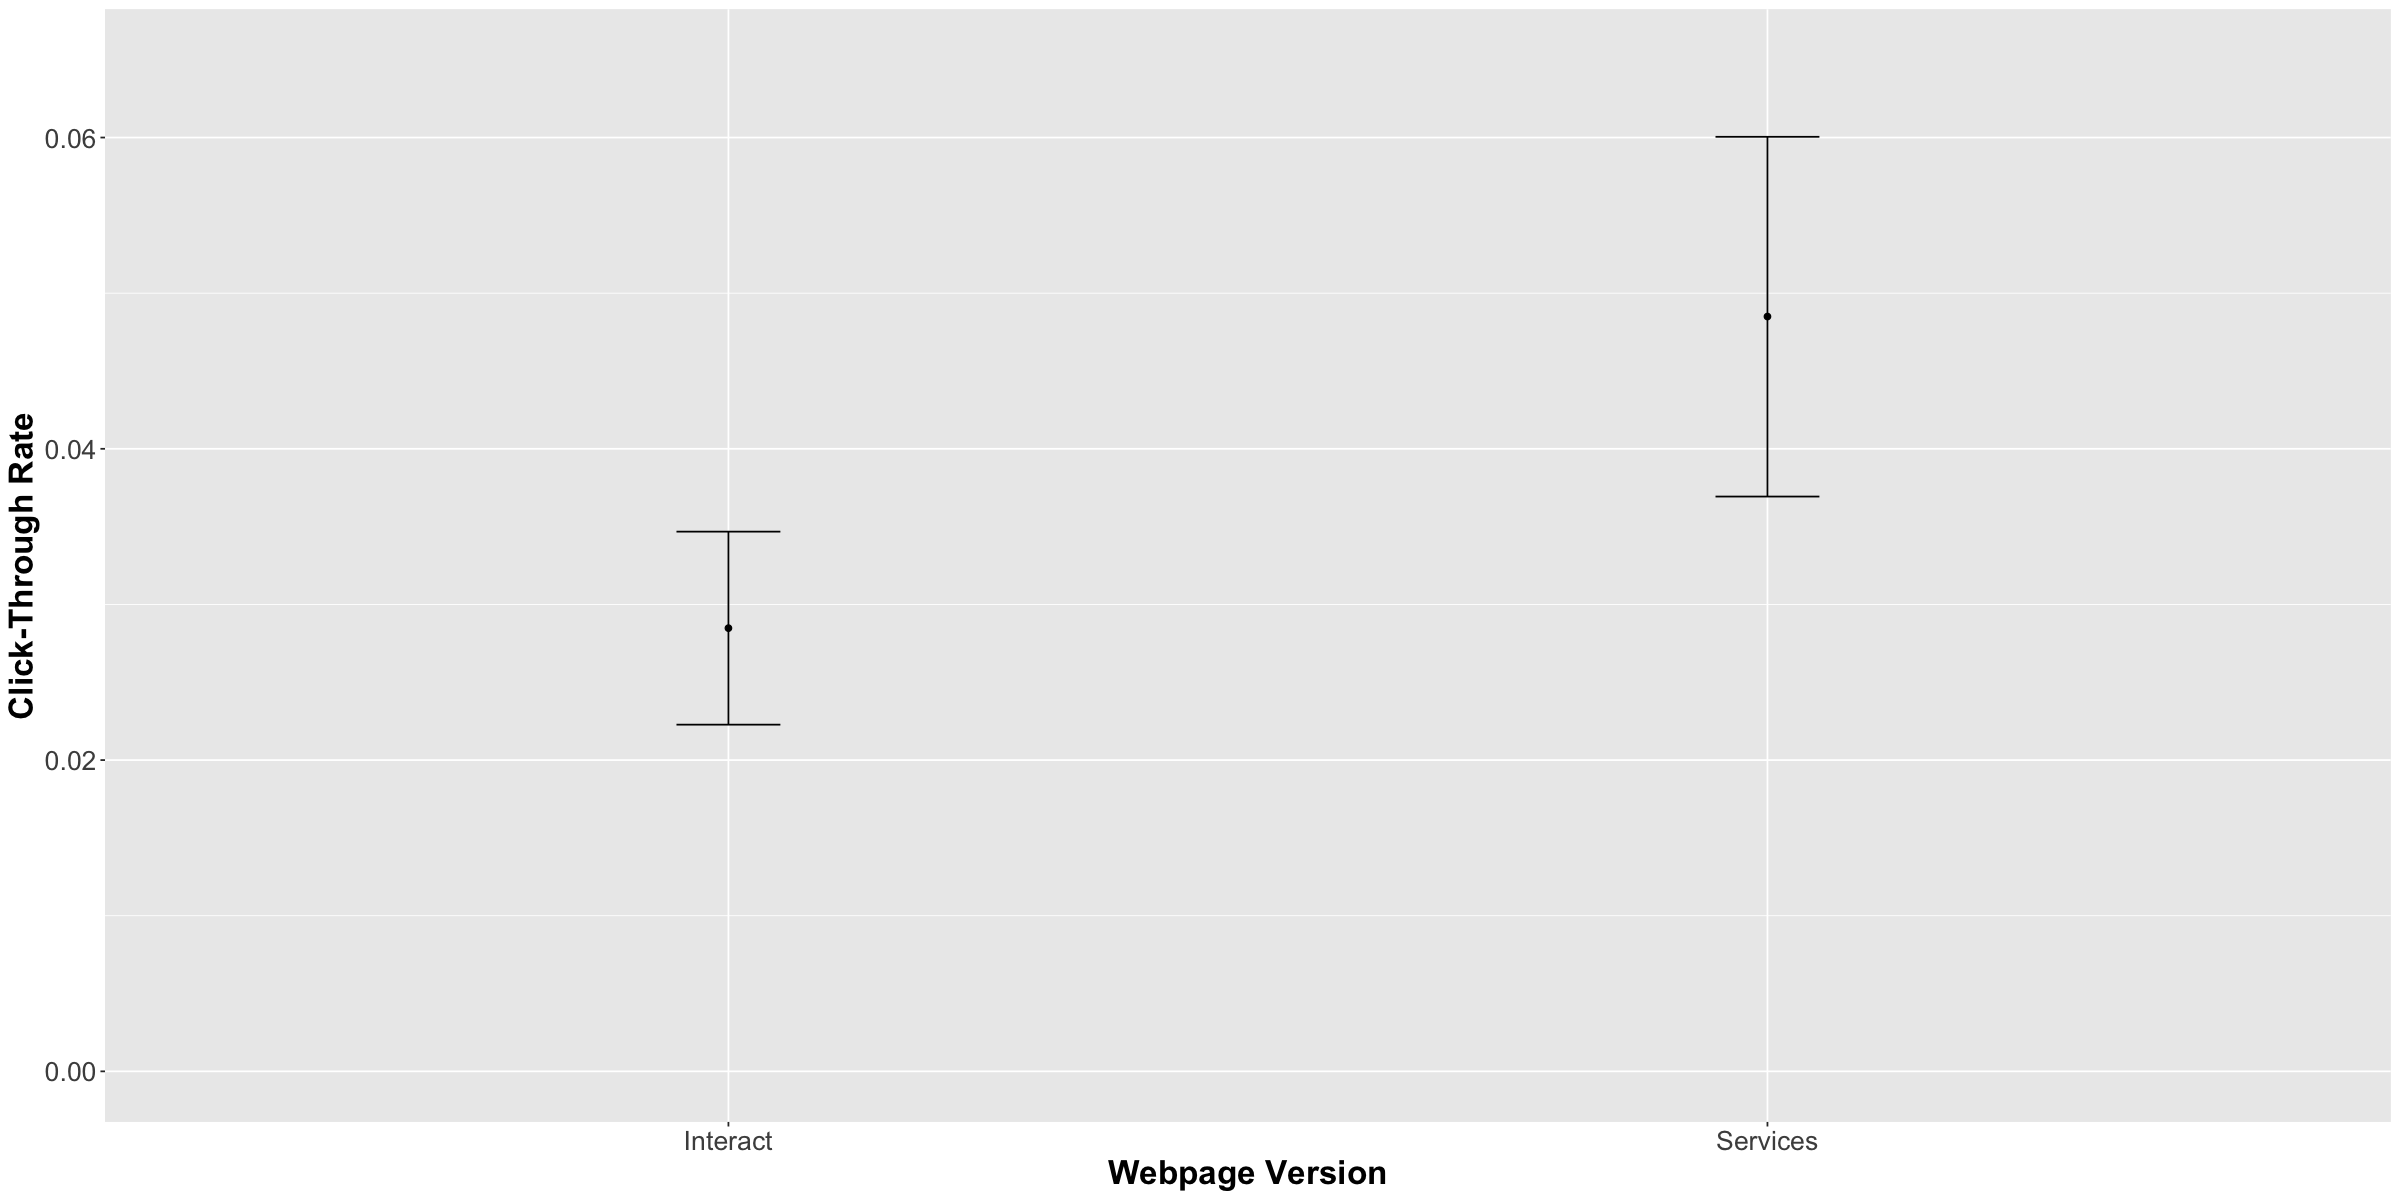

In [9]:
# Visualization
options(repr.plot.width = 20, repr.plot.height = 10)
ggplot(click_through_est, aes(x = webpage, y = click_rate)) +
    geom_point() +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.1) +
    xlab("Webpage Version") +
    ylab("Click-Through Rate") +
    theme(text = element_text(size=20)) +
    ylim(c(0, 0.065)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
  )

**There is indeed *graphical evidence* that both intervals do not overlap. Nonetheless, they are pretty close! We need to go statistically further.**

### 3.6. Follow the six steps of Hypothesis Testing

#### 3.6.1. Define the null and alternative hypotheses.

Suppose **we want to infer if the *Services* version has a higher CTR than the *Interact* version**. This is a **one-sided test**:

$H_0$: The CTR for the *Interact* version of the website is **the same as** the CTR for the *Services* version of the website (i.e., $p_{I} = p_{S}$).

$H_A$: The CTR for the *Services* version of the website is **higher than** the CTR for the *Interact* version of the website (i.e., $p_{I} < p_{S}$).

Note that $\delta$ can be defined as follows:

$$
H_0: \underbrace{\delta}_{p_{S} - p_{I}} = 0
$$

$$
H_A: \underbrace{\delta}_{p_{S} - p_{I}} > 0
$$

Then, a reasonable test statistic is the difference of sample proportions: 

$$\delta^* = \hat{p}_{S} - \hat{p}_{I}.$$

#### 3.6.2. Compute the **observed** test statistic $\delta^*$ coming from your original sample.

In [11]:
click_through_est

webpage,click_rate,treatment_size,lower_ci,upper_ci
<chr>,<dbl>,<int>,<dbl>,<dbl>
Interact,0.02847709,2423,0.02227610,0.03467809
Services,0.04849885,1299,0.03693226,0.06004619


In [12]:
delta_star <- diff(click_through_est$click_rate)
round(delta_star, 5)

[1] 0.02002

#### 3.6.3. Use the null model to generate $r$ **random permuted** samples from the original sample and calculate their corresponding $r$ test statistics.

We use the `infer` package to now generate $r = 1000$ random permuted samples under $H_0$. For each simulated sample, we calculate a test statistic.

In [13]:
set.seed(1234) # For reproducibility.
null_distribution_webpage <- click_through %>%
  specify(formula = click_target ~ webpage, success = "1") %>%
  hypothesize(null = "independence") %>%
  generate(reps = 1000, type = "permute") %>%
  calculate(stat = "diff in props", order = c("Services", "Interact"))
null_distribution_webpage

replicate,stat
<int>,<dbl>
1,-0.001263869
2,-0.004811473
3,-0.007176542
⋮,⋮
998,-0.001263869
999,0.008196406
1000,0.007013872


#### 3.6.4. Generate the null distribution using these $r$ test statistics.

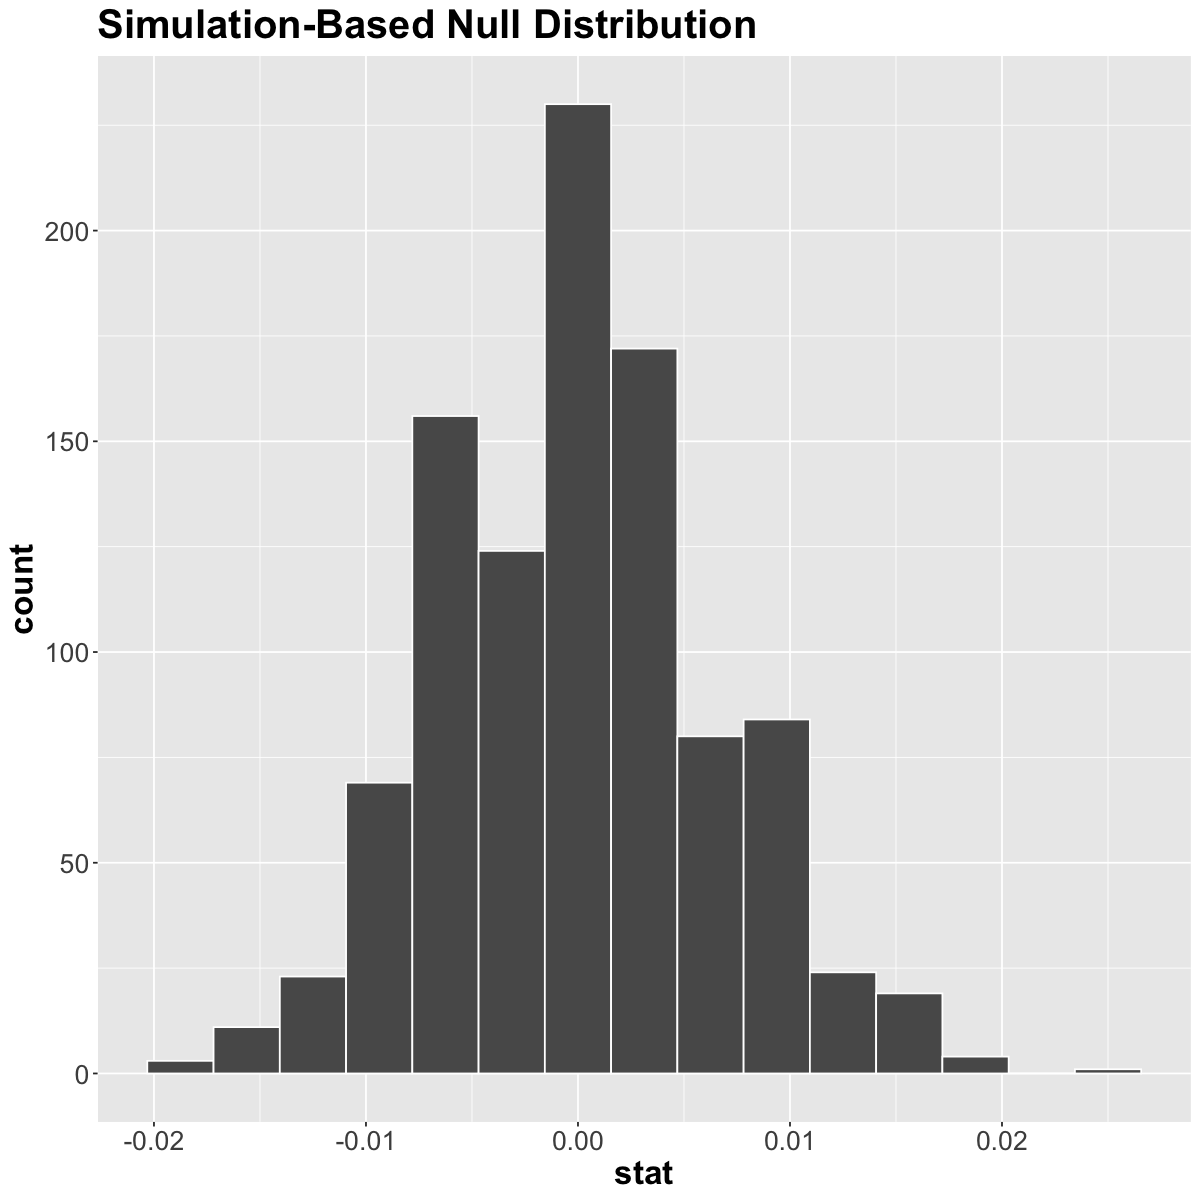

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10) 
h0_dist <- null_distribution_webpage %>% 
    visualize() +
    theme(text = element_text(size=20)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
  )
h0_dist 

#### 3.6.5. Check where your **observed** test statistic $\delta^*$ falls on this distribution.

Firstly, visualize the threshold for rejecting $H_0$ on this distribution with a significance level $\alpha = 0.05$. **This is a one-sided test**; thus, we will use `quantile()` to calculate the 0.95th quantile of this distribution.

In [15]:
alpha_threshold <- quantile(null_distribution_webpage$stat, 0.95)

h0_dist <- h0_dist + geom_vline(
  xintercept = alpha_threshold,
  color = "blue", lty = 5, size = 2
)

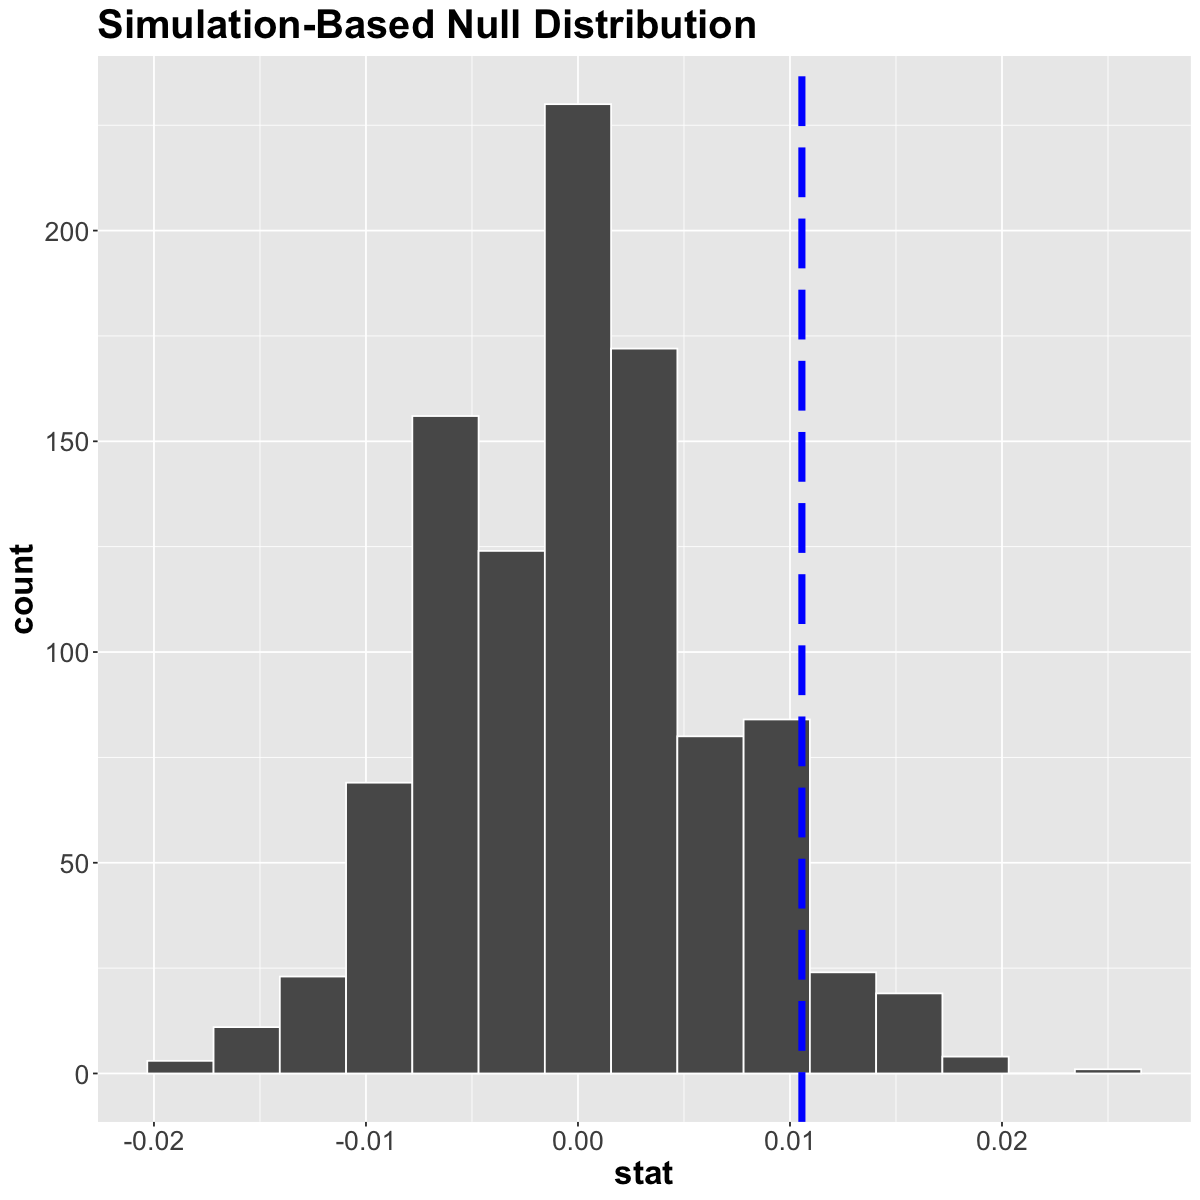

In [16]:
h0_dist

Where is our sample test statistic $\delta^*$ on this distribution?

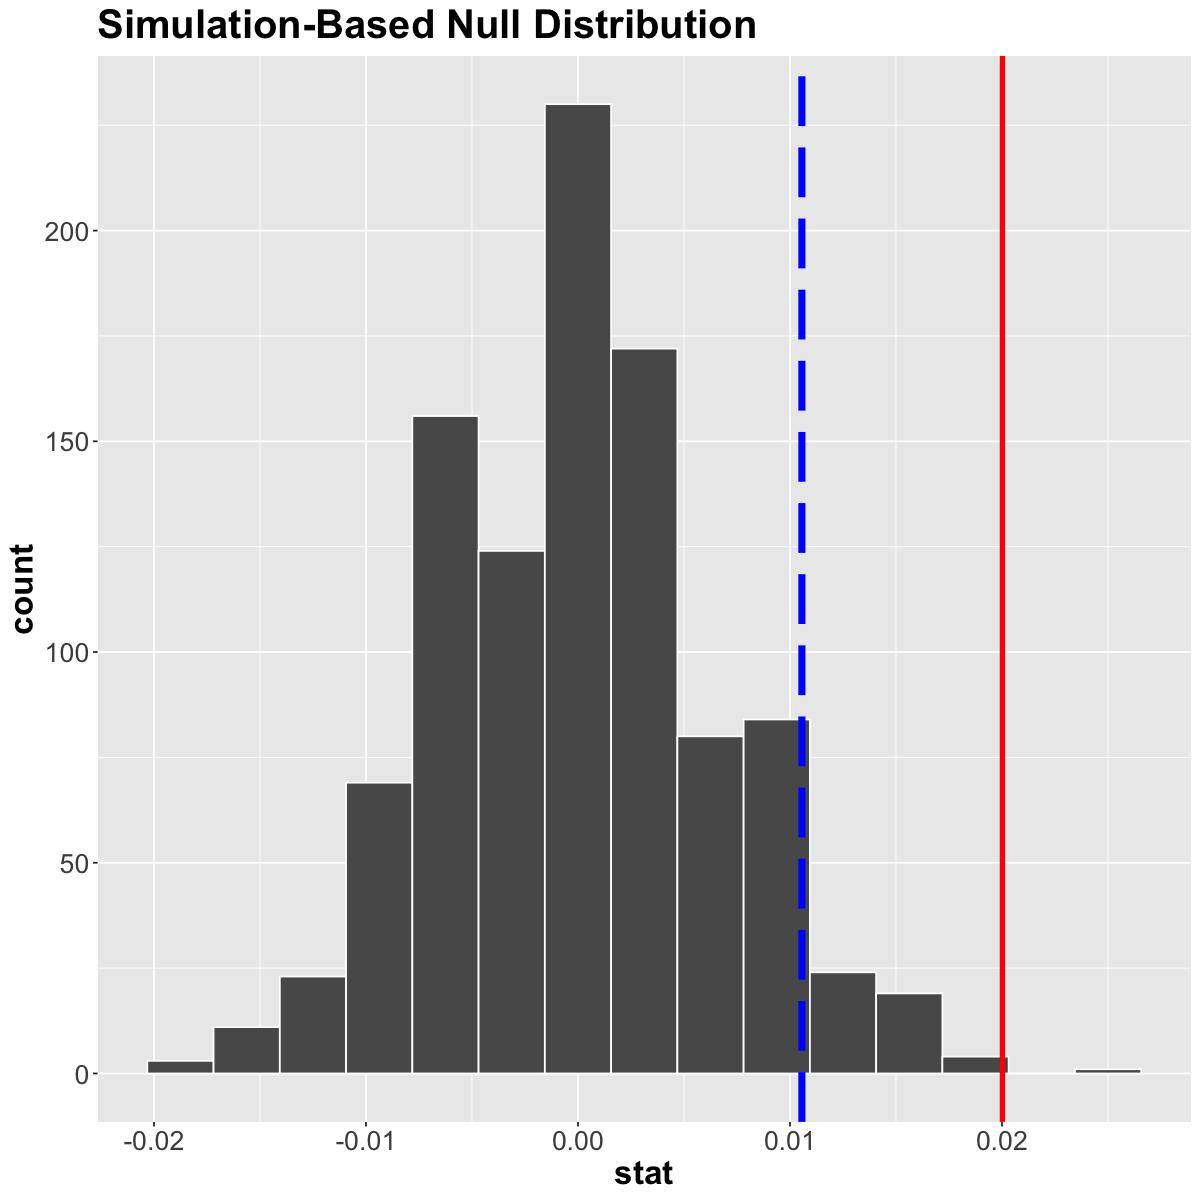

In [17]:
h0_dist <- h0_dist +
    geom_vline(xintercept = delta_star, color = "red", size = 1.5)
h0_dist

#### 3.6.6. If $\delta^*$ is near the extreme past some threshold defined with a significance level $\alpha$, we reject the null hypothesis. Otherwise, we fail to reject the null hypothesis.

Since our **observed test statistic** is large enough to lie beyond the significance threshold, we reject $H_0$ in favour of $H_A$.

### 3.7. $p$-value

In real life, we compute a $p$-value to determine whether our test statistic lies beyond the significance threshold.

$p$-value describes: In what percentage of the simulations was the difference in sample proportions at least as extreme as the observed difference proportion $\delta^*$?

We can calculate $p$-value easily with `infer`.

In [18]:
null_distribution_webpage %>%
  get_pvalue(obs_stat = delta_star, direction = "greater")

p_value
<dbl>
0.001


Calculating the $p$-value, instead of creating a visualization as we did above, leads us to the same conclusion:

*Given that our $p$-value is < 0.05 (our defined significance threshold $\alpha$), we can reject the null hypothesis $H_0$ (the CTRs for both website versions are the same) in favour of the alternative hypothesis $H_A$.*

This is how we calculate the simulation's $p$-value "manually":

In [19]:
sum(null_distribution_webpage$stat >= delta_star) / 1000 

[1] 0.001